# Homework 3

This homework will explore linear regression and resampling techniques by analyzing data from a database of glaciers. The database is *Glatilda* for [*Glacier Ice Thickness Database*](!https://www.gtn-g.ch/data_catalogue_glathida/).

1. Data prep (5 points)
2. Mapping (10 points)
3. Correlations between parameters (5 points)
4. Linear regression and resampling techniques (10 points)

## 1. Data Prep (5 points total)

### a) Download data (1 point) 
The database is saved on a GitLab repository that you may clone: https://gitlab.com/wgms/glathida.git



In [2]:
# answer
# git clone https://gitlab.com/wgms/glathida.git

### b) Import Python modules (1 point) 
Import pandas, geopandas, plotting, raster files,  numpy, netcdf

In [3]:
# solution
import pandas as pd
#import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
#import netCdf3
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode'
import io
import requests
import time
from datetime import datetime, timedelta
#from folium.plugins import MarkerCluster
from rasterio.mask import mask
from rasterio.plot import show

### c) Read data (2 points)
Read the glacier data from the file ``glathida/data/glacier.csv`` into a pandas data frame, and decribe briefly the dataframe content and its first few lines.

In [4]:
# Solution
t_path = "glathida/data/glacier.csv"
df = pd.read_csv(t_path)
df1=df.dropna(subset=['area','mean_thickness'])
df.describe()

,id,survey_id,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles
count,1013.000000,1013.000000,1013.000000,1013.000000,985.000000,426.000000,498.000000,127.000000,525.000000,135.000000,593.000000,68.000000,141.000000
mean,1395.566634,130.707799,57.084700,14.987602,217.599979,9.091549,70.375502,7.125984,197.563810,10.074074,3086.131535,15.779412,48.587333
std,1085.433643,75.321429,29.473871,51.341702,1602.939314,5.806169,69.053311,5.988073,199.968677,6.977180,8117.336773,17.335018,183.175981
min,1.000000,1.000000,-74.583300,-151.300000,0.026400,0.000000,4.000000,0.000000,12.000000,1.000000,1.000000,1.000000,0.140000
25%,325.000000,69.000000,46.453610,10.700000,2.204000,6.000000,33.250000,3.000000,95.000000,5.000000,46.000000,6.000000,3.000000
50%,1995.000000,128.000000,62.039400,14.687100,10.959000,8.000000,51.000000,5.000000,140.000000,8.000000,189.000000,10.500000,9.500000
75%,2254.000000,203.000000,78.776000,22.280000,98.341000,12.000000,74.000000,9.000000,230.000000,13.000000,2018.000000,21.000000,22.500000
max,6631.000000,256.000000,81.767200,170.320000,40000.000000,48.000000,541.000000,30.000000,2500.000000,36.000000,67542.000000,120.000000,1657.000000


**Explore the data with visualization**
Before making any inference of models with the data, we will start by exploring basic correlations among parameters by plotting. In particular, we will focus on ``mean_thickness``, ``area``, ``mean_slope`` parameters.

### d) Remove bad data (1 point)

The database may contain Nans and other "bad" values (welcome to the data world!). First we will clean the data by removing nans. We are mostly interested in the thickness, area, and slope



In [5]:
#answer below 
df.dropna(subset=['date','area','mean_slope','mean_thickness'],inplace=True)
df.head(5)

,id,survey_id,name,external_db,external_id,lat,lon,date,max_date,area,...,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,interpolation_method,flag,remarks
32,33,9,Easton Glacier,FOG,1367,48.75000,-121.83000,1992-01-01,1992-12-31,2.9,...,58.0,NaN,107.0,NaN,64.0,NaN,NaN,NaN,NaN,NaN
33,34,10,Lemon Creek Glacier,FOG,3334,58.38000,-134.36000,1956-06-21,1956-09-22,11.7,...,66.0,NaN,200.0,NaN,182.0,NaN,NaN,NaN,NaN,NaN
47,48,16,Kavrayskogo,WGI,SU5X13207002,45.23645,80.78166,1962-01-01,1962-12-31,3.2,...,49.0,NaN,116.0,NaN,NaN,NaN,NaN,NaN,NaN,LAT/LON: FoG 2009
48,49,16,Krasovskogo,WGI,SU5X13207003,45.23513,80.80835,1962-01-01,1962-12-31,3.4,...,49.0,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,LAT/LON: Katalog Lednikow
49,50,17,214,WGI,SU5X13205214,44.92845,79.13669,1981-01-01,1981-12-31,1.0,...,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEAN_SLOPE: Bahr et al. 1997 (https://doi.org/...


## 2. Mapping glaciers (10 points)

Make a global map of the glaciers. Use either of the tools we learned in class:
* Geopandas, DEMs from NetCDFfiles (see chapter 2.4)
* Pandas and Plotly (see chapter 2.2). You may need to transform some of the series into log-spaced values for better visualization.

### Option 1: Tif and matplotlib

You can use the ``elevation`` data from the DEM seen in class. Download the DEM file (https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif?dl=1)

In [6]:
# solution
fname="HYP_50M_SR.tif"
elevation = rasterio.open(fname)



___Tips___: when plotting a image in ``matplotlib`` you need to add information about the physical dimensions of the image. You can calculate the ``bounds``.

In [7]:
bounds = (elevation.bounds.left, elevation.bounds.right, \
          elevation.bounds.bottom, elevation.bounds.top)

We will use ``matplotlib.pyplot`` to show the raster image in the background (tips: use ``imshow()``. The raster image in matplotlib can only import one frame and not three (R, G, B) frames. We will first stack the three images together. 

In [8]:
red = elevation.read(1)
green = elevation.read(2)
blue = elevation.read(3)
pix = np.dstack((red, green, blue))

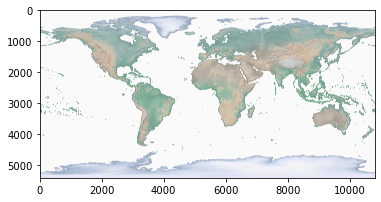

<AxesSubplot:>

In [9]:
# solution
image = elevation.read()
show(image)

## Option 2: Plotly

You may use plotly. For improved visibility, transform some of the data into log-spaced. You may add these transformed Series into the Pandas, and use them as input to plotly.

In [10]:

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode' # writes as standalone html, 
# pio.renderers.default = 'iframe' # writes files as standalone html, 
# pio.renderers.default = 'png' # writes files as standalone html, 
# try notebook, jupyterlab, png, vscode, iframe

In [11]:
# solution
fig = px.scatter_geo(df,
                     lat='lat',lon='lon', 
                     range_color=(1,9),
                     height=600, width=600,
                     size='id',color='area',
                     hover_name="id",
                     hover_data=['id','area','mean_slope','mean_thickness']);
fig.update_geos(resolution=110, showcountries=True)
fig.update_geos(resolution=110, showcountries=True,projection_type="orthographic")

## 3. Correlations between data parameters ( 5 points total)

Make plots to vizualise the correlation, or lack of, between all three data. Make at least three plots.

### a) Basic correlations using Matplotlib (2 points)

Make 3 plots using matplotlib to visualize slope, mean_thickness, and area. Use logscale to see the correlatons.

__Tips__: 
* Use the function ``scatter`` to plot the values of mean thickness, mean slope, area, and latitude. 
* use one of the dataframe columns as a color using the argument ``c``. You can also vary the ``colormap`` using the argument ``cmap``. Help on colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html. Be mindful of Color-Vision Deficient readers and read *Crameri, F., Shephard, G.E. and Heron, P.J., 2020. The misuse of colour in science communication. Nature communications, 11(1), pp.1-10. https://doi.org/10.1038/s41467-020-19160-7* (find it on the class Gdrive). You can add a third "data" by choosing a marker color that scales with an other parameter. For instance, try coloring your marker with the ``LAT`` parameter to look at systematic latitudinal trends from the equator to the poles.
* Do not forget to adjust fontsize, figure size (at least 10,8), grid, labels with units. ou may also explore the *logarithmic* correlations by mapping the axis from linear to logarithmic scale ``plt.xscale('log')``.

C:\Users\jepul\AppData\Local\Temp\ipykernel_32596\2065560913.py:9: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().

C:\Users\jepul\AppData\Local\Temp\ipykernel_32596\2065560913.py:17: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



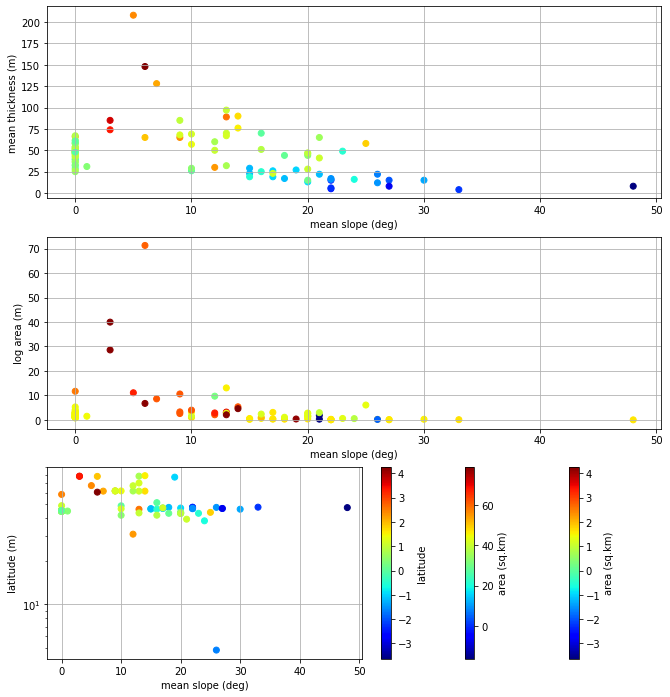

In [14]:
# Figure 1: Mean slope vs mean thickness
# solution
fig1,ax = plt.subplots(3,1,figsize=(11,12))
im = ax[0].scatter(df.mean_slope,df.mean_thickness,c=np.log(df.area),cmap='jet')
ax[0].set_xlabel('mean slope (deg)')
ax[0].set_ylabel('mean thickness (m)')
ax[0].grid(True)
plt.yscale('log')
cbar0 = plt.colorbar(im)
cbar0.set_label('area (sq.km)')

im1 = ax[1].scatter(df.mean_slope,df.area,c=df.lat,cmap='jet')
ax[1].set_xlabel('mean slope (deg)')
ax[1].set_ylabel('log area (m)')
ax[1].grid(True)
plt.yscale('log')
cbar2 = plt.colorbar(im1)
cbar2.set_label('area (sq.km)')

im2 = ax[2].scatter(df.mean_slope,df.lat,c=np.log(df.area),cmap='jet')
ax[2].set_xlabel('mean slope (deg)')
ax[2].set_ylabel('latitude (m)')
ax[2].grid(True)
#plt.yscale('log')
cbar1 = plt.colorbar(im2)
cbar1.set_label('latitude')


### b) 3D Scatter plot using Plotly (1 point)

Use the plotly ``scatter_3d`` plot. Make sure to change the pandas series for log scales.

In [16]:
# solution

fig = px.scatter_3d(df,x=df.area,y=df.mean_slope,z=df.mean_thickness,
                    log_x=True,width=800, height=800);
fig.show()

### c) Pandas Correlation function (1 point)

You may use Pandas functionalities to explore correlation between data. Use the function ``corr`` on the dataframe and the matplotlib function ``matshow`` to plot a heatmap of the correlations

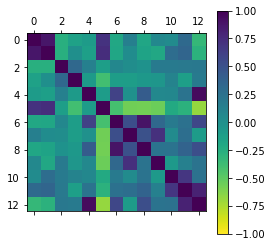

In [17]:
#solution
im = plt.matshow(df1.corr(), cmap='viridis_r', vmin=-1, vmax=1)
plt.colorbar(im)

In [18]:
print(df1.columns)
df1.head()

Index(['id', 'survey_id', 'name', 'external_db', 'external_id', 'lat', 'lon',
       'date', 'max_date', 'area', 'mean_slope', 'mean_thickness',
       'mean_thickness_uncertainty', 'max_thickness',
       'max_thickness_uncertainty', 'number_points', 'number_profiles',
       'length_profiles', 'interpolation_method', 'flag', 'remarks'],
      dtype='object')


,id,survey_id,name,external_db,external_id,lat,lon,date,max_date,area,...,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,interpolation_method,flag,remarks
0,1,1,Isfallsglaciären,WGI,SE4B000E0006,67.91500,18.56800,1979-03-01,1979-03-31,1.3,...,72.0,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,Rabots glaciär,WGI,SE4B000E1016,67.91000,18.49600,1979-03-01,1979-03-31,4.1,...,84.0,NaN,175.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN
2,3,1,Storglaciären,WGI,SE4B000E0005,67.90000,18.57000,1979-03-01,1979-03-31,3.1,...,99.0,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,South Cascade Glacier,WGI,US2M00264006,48.35698,-121.05735,1975-01-01,1975-12-31,2.0,...,99.0,NaN,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,Athabasca Glacier,FOG,7,52.17540,-117.28400,NaN,NaN,3.8,...,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### f) Seaborn Plotting (1 point)

Seaborn is a great python package for basic data anlytics. See documentation [here](!https://seaborn.pydata.org/).

In [19]:
#solution
# New dataframe to make new calculations
df2 = df1.copy()
df2.dropna(subset=['date','area','mean_slope','mean_thickness'],inplace=True)
df2 = df2.drop(['id', 'survey_id', 'name', 'external_db', 'external_id', 'date', 
                'max_date', 'interpolation_method', 'flag', 'remarks'], axis=1)
df2.head()

,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles
32,48.75000,-121.83000,2.9,0.0,58.0,NaN,107.0,NaN,64.0,NaN,NaN
33,58.38000,-134.36000,11.7,0.0,66.0,NaN,200.0,NaN,182.0,NaN,NaN
47,45.23645,80.78166,3.2,0.0,49.0,NaN,116.0,NaN,NaN,NaN,NaN
48,45.23513,80.80835,3.4,0.0,49.0,NaN,139.0,NaN,NaN,NaN,NaN
49,44.92845,79.13669,1.0,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN


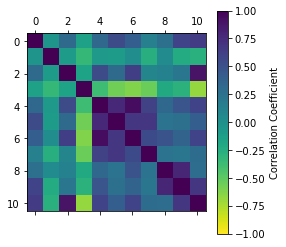

In [20]:
plt.matshow(df2.corr(), cmap='viridis_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')

<AxesSubplot:>

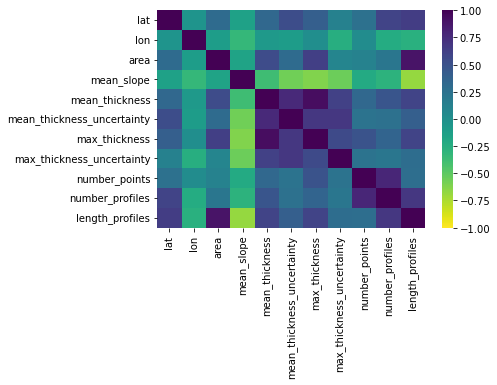

In [21]:
# solution
import seaborn as sns
sns.heatmap(df2.corr(), cmap='viridis_r', vmin=-1, vmax=1)

Discuss the basic correlations among the data. Do these correction make sense when you think about the shapes of glaciers?

<AxesSubplot:>

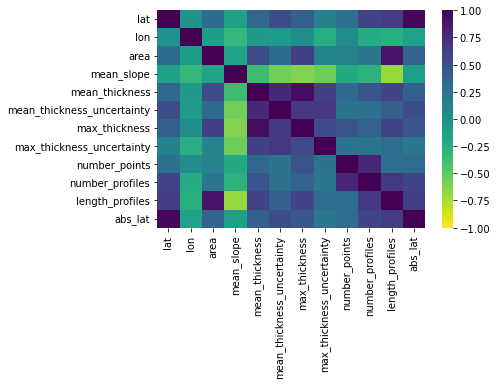

In [22]:
df3 = df2.copy()
df3['abs_lat'] = abs(df3['lat']) 
sns.heatmap(df3.corr(), cmap='viridis_r', vmin=-1, vmax=1)

## 4. Linear Regression (10 points total counted in the next section)
You found from basic data visualization that the three parameters ``mean_slope``, ``mean_thickness``, and ``area`` are correlated. It does make physical sense because a *steep* glaciers is likely to be in the high mountains regions, hanging on the mountain walls, and thus be constrained, and conversely, a flat glacier is either at its valley, ocean terminus or on ice sheets.

### a) Simple linear regression (2 points)
We will now perform a regression between the parameters (or their log!). Linear regressions are models that can be imported from scikit-learn. Log/exp functions in numpy as ``np.log()`` and ``np.exp()``.
Remember that a linear regression is finding $a$ and $b$ knowing both $x$ and the data $y$ in $y = Ax +b$. We want to predict ice thickness from a crude estimate of the glacier area.

__Tips__: 
a. make sure that the dimensions are correct and that there is no NaNs and zeros.
b. Make sure to inport the scikit learn linear regression function and the error metrics.

In [23]:
# solution
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df4 = df2.dropna(subset=['area','mean_thickness', 'mean_slope'])
df4.head()

,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles
32,48.75000,-121.83000,2.9,0.0,58.0,NaN,107.0,NaN,64.0,NaN,NaN
33,58.38000,-134.36000,11.7,0.0,66.0,NaN,200.0,NaN,182.0,NaN,NaN
47,45.23645,80.78166,3.2,0.0,49.0,NaN,116.0,NaN,NaN,NaN,NaN
48,45.23513,80.80835,3.4,0.0,49.0,NaN,139.0,NaN,NaN,NaN,NaN
49,44.92845,79.13669,1.0,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN


Make a plot of the data and the linear regression your performed

In [24]:
df4['log_area'] = np.log(df4['area'])
df4['log_mean_thickness'] = np.log(df4['mean_thickness'])
df4.head()

,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,log_area,log_mean_thickness
32,48.75000,-121.83000,2.9,0.0,58.0,NaN,107.0,NaN,64.0,NaN,NaN,1.064711,4.060443
33,58.38000,-134.36000,11.7,0.0,66.0,NaN,200.0,NaN,182.0,NaN,NaN,2.459589,4.189655
47,45.23645,80.78166,3.2,0.0,49.0,NaN,116.0,NaN,NaN,NaN,NaN,1.163151,3.891820
48,45.23513,80.80835,3.4,0.0,49.0,NaN,139.0,NaN,NaN,NaN,NaN,1.223775,3.891820
49,44.92845,79.13669,1.0,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,3.951244


In [25]:
df5 = df4.copy()
df5 = df5.loc[(df5['mean_slope']!=0)] # drop rows where slope==0
df5.head()

,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,log_area,log_mean_thickness
72,44.70490,79.71810,1.50000,1.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.405465,3.433987
255,30.85500,78.81800,9.70000,12.0,30.0,NaN,120.0,NaN,NaN,8.0,NaN,2.272126,3.401197
273,48.62495,-113.75707,1.00000,10.0,26.0,NaN,80.0,NaN,NaN,9.0,NaN,0.000000,3.258097
276,46.95950,9.38910,0.08068,22.0,15.0,5.0,36.0,5.0,5936.0,34.0,4.83,-2.517265,2.708050
384,47.41390,10.97200,0.30700,18.0,17.0,2.0,52.0,2.0,448.0,11.0,2.20,-1.180908,2.833213


(97,) (97, 1)
64 64 33 33
Coefficients: 
 [1.71176564]
Mean squared error: 0.62
Coefficient of determination: 0.68


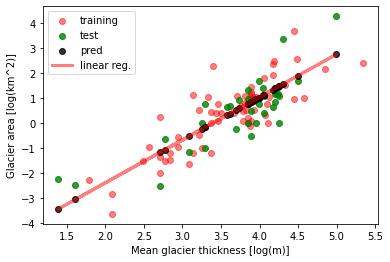

In [26]:
# solution
# solution
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(df4['log_mean_thickness'], axis=1),df4['log_area'], test_size=0.33, random_state=42)
print(df4['log_mean_thickness'].shape, np.expand_dims(df4['log_mean_thickness'], axis=1).shape)
print(len(X_train), len(y_train), len(X_test), len( y_test))

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_train, y_train, color="red", label='training', alpha=0.5)
plt.scatter(X_test, y_test, color="green", label='test', alpha=0.8)
plt.scatter(X_test, y_pred, color="black", label='pred', alpha=0.8)
plt.plot(X_test, y_pred, color="red", linewidth=3, label='linear reg.', alpha=0.5)
plt.xlabel('Mean glacier thickness [log(m)]')
plt.ylabel('Glacier area [log(km^2)]')
plt.legend()

**Briefly comment on the quality of your fit and a linear regression (1 point)**

(60,) (60, 1)
40 40 20 20
Coefficients: 
 [-6.25619174]
Mean squared error: 62.73
Coefficient of determination: 0.41


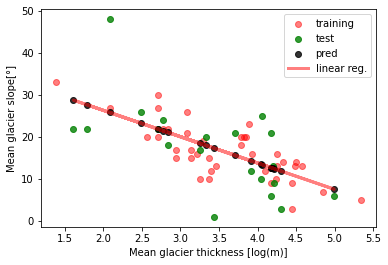

In [27]:
# solution
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(df5['log_mean_thickness'], axis=1),df5['mean_slope'], test_size=0.33, random_state=42)
print(df5['log_mean_thickness'].shape, np.expand_dims(df5['log_mean_thickness'], axis=1).shape)
print(len(X_train), len(y_train), len(X_test), len( y_test))

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_train, y_train, color="red", label='training', alpha=0.5)
plt.scatter(X_test, y_test, color="green", label='test', alpha=0.8)
plt.scatter(X_test, y_pred, color="black", label='pred', alpha=0.8)
plt.plot(X_test, y_pred, color="red", linewidth=3, label='linear reg.', alpha=0.5)
plt.xlabel('Mean glacier thickness [log(m)]')
plt.ylabel('Mean glacier slope[°]')
plt.legend()

The fit looks pretty good, except that there are outliers on the extreme low and high values of mean area.

In [28]:
print(df4['log_mean_thickness'].shape, np.expand_dims(df5['log_mean_thickness'], axis=1).shape)
print(len(X_train), len(y_train), len(X_test), len( y_test))

(97,) (60, 1)
40 40 20 20


In [29]:
X = df5[['log_mean_thickness', 'log_area']]
y = df5['mean_slope']

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.33, random_state=42)
print(len(X_train), len(y_train), len(X_test), len( y_test))

regr = LinearRegression()
regr.fit(X, y)

#predict the CO2 emission of a car where the weight is 2300kg, and the volume is 1300cm3:
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

40 40 20 20
Coefficients: 
 [-1.71593917 -2.88553514]
Mean squared error: 52.52
Coefficient of determination: 0.50


In [30]:
df5['color'] = [None]*len(df5) # add an empty column to df
for idx, row in df5.iterrows():
    if idx in X_train.index:
        df5.loc[idx,['color']] = 'training'
    elif idx in X_test.index:
        df5.loc[idx,['color']] = 'test'
df5.head()

,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,log_area,log_mean_thickness,color
72,44.70490,79.71810,1.50000,1.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.405465,3.433987,test
255,30.85500,78.81800,9.70000,12.0,30.0,NaN,120.0,NaN,NaN,8.0,NaN,2.272126,3.401197,training
273,48.62495,-113.75707,1.00000,10.0,26.0,NaN,80.0,NaN,NaN,9.0,NaN,0.000000,3.258097,training
276,46.95950,9.38910,0.08068,22.0,15.0,5.0,36.0,5.0,5936.0,34.0,4.83,-2.517265,2.708050,test
384,47.41390,10.97200,0.30700,18.0,17.0,2.0,52.0,2.0,448.0,11.0,2.20,-1.180908,2.833213,test


In [31]:
df6 = pd.DataFrame() # test data set
df6['Xtest_thick'] = X_test['log_mean_thickness']
df6['Xtest_area'] = X_test['log_area']
df6['y_test'] = y_test # slope
df6['y_pred'] = y_pred # slope
df6.head()

,Xtest_thick,Xtest_area,y_test,y_pred
72,3.433987,0.405465,1.0,16.338231
385,1.609438,-2.476938,22.0,27.786323
585,4.304065,3.353057,3.0,6.339850
601,3.912023,1.047319,12.0,13.665858
525,2.079442,-3.634391,48.0,30.319696


In [32]:
df6t = pd.DataFrame() # trainings data set
df6t['Xtrain_thick'] = X_train['log_mean_thickness']
df6t['Xtain_area'] = X_train['log_area']
df6t['y_train'] = y_train # slope
df6t.head()

,Xtrain_thick,Xtain_area,y_train
598,3.891820,-0.510826,23.0
531,2.564949,-0.940020,20.0
583,4.574711,1.015231,13.0
745,3.295837,-0.994252,19.0
537,4.234107,1.171708,10.0


In [33]:
# solution
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Scatter3d(x=df6['Xtest_thick'], y=df6['y_test'], z=df6['Xtest_area'], mode='markers',
                 marker=dict(color='black'), opacity=0.3, name='test'),
    go.Scatter3d(x=df6['Xtest_thick'], y=df6['y_pred'], z=df6['Xtest_area'], mode='markers',
             marker=dict(color='green'), opacity=0.5, name='pred'),
    go.Scatter3d(x=df6t['Xtrain_thick'], y=df6t['y_train'], z=df6t['Xtain_area'], mode='markers',
         marker=dict(color='yellow'), opacity=0.3, name='train')])

    #go.Scatter3d(x=df10["Xtest_thick"], y=df10["y_pred"], z=df10["Xtest_area"], mode='lines')])
fig.update_layout(scene = dict(
                    xaxis_title='Mean glacier thickness [log(m)]',
                    yaxis_title='Mean glacier slope [°]',
                    zaxis_title='Mean glacier area [log(km^2)]'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

### b) Leave One Out Cross Validation linear regression (1 point)


Perform the LOCCV on the ``area`` and ``thickness`` values. Predict the ``thickness`` value knowing a ``area`` value. Use material seen in class. Make a plot of your fit.

In [34]:
from sklearn.model_selection import LeaveOneOut
# solution
loo = LeaveOneOut()

In [35]:
df7 = df5.copy()
df7 = df7.reset_index()
df7.head()

,index,lat,lon,area,mean_slope,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,log_area,log_mean_thickness,color
0,72,44.70490,79.71810,1.50000,1.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.405465,3.433987,test
1,255,30.85500,78.81800,9.70000,12.0,30.0,NaN,120.0,NaN,NaN,8.0,NaN,2.272126,3.401197,training
2,273,48.62495,-113.75707,1.00000,10.0,26.0,NaN,80.0,NaN,NaN,9.0,NaN,0.000000,3.258097,training
3,276,46.95950,9.38910,0.08068,22.0,15.0,5.0,36.0,5.0,5936.0,34.0,4.83,-2.517265,2.708050,test
4,384,47.41390,10.97200,0.30700,18.0,17.0,2.0,52.0,2.0,448.0,11.0,2.20,-1.180908,2.833213,test


In [36]:
X = np.expand_dims(df7['area'], axis=1)
y = df7['mean_thickness']

In [37]:
for train_indexes, test_indexes in loo.split(X):
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    X_test = X[test_indexes]
    y_test = y[test_indexes]
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

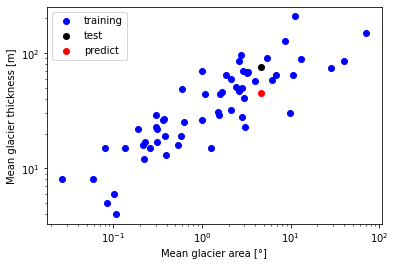

In [38]:
# lot prediction and test
plt.scatter(X_train[:,0], y_train, color='blue', label='training')
plt.scatter(X_test[:,0], y_test, color='black', label='test')
plt.scatter(X_test[:,0], y_pred, color='red', label='predict')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean glacier area [°]')
plt.ylabel('Mean glacier thickness [m]')
plt.legend()

### c) Bootstrapping (1 point)

Perform the same analysis but using a bootstrapping technique. Output the mean and standard deviation of the slope. An illustration with a histogram  may help.

In [47]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
# solution
X = df5[['area']] # np.expand_dims(X, axis=1)
y = df5['mean_slope']

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
print(len(X_train), len(y_train), len(X_test), len( y_test))

# bootstrap predictions
accuracy = []
mean_l = []
std_l = []

X_bs_l = []
y_bs_l = []
y_hat_l =[]
y_10_l = []

k=100
df_10 = pd.DataFrame() # create df
df_10['area'] = [10]*k # add column to df filled with 10 (because we want to predict slope for area = 10)

for i in range(k):
    # resample the trainings data set
    X_bs, y_bs = resample(X_train, y_train, replace=True)
    # Train the model using the training sets
    regr.fit(X_bs, y_bs)
    # Predictions
    y_hat = regr.predict(X_bs) # predict for actual test data set
#    y_hat = regr.predict(X_test) # predict for actual test data set
    y_10 = regr.predict(df_10)[0] # predict slope for area 10km^2
    
    # append the model output to lists
    X_bs_l.append(X_bs)
    y_bs_l.append(y_bs)
    y_hat_l.append(y_hat)
    y_10_l.append(y_10)

    # evaluate model
    score = accuracy_score(np.array(y_bs), np.around(y_hat))
    accuracy.append(score)
 
    # The coefficients
    mean = round(np.nanmean(y_hat),2)
    std = round(np.std(y_hat),2)
    mean_l.append(mean)
    std_l.append(std)

print('Length training data set: {} \nLength unique indeces training data set: {}'.format(len(X_bs.index),len(np.unique(X_bs.index))))

print('y_predict mean:  ', mean)
print('y_predict std:  ',std)


40 40 20 20
Length training data set: 40 
Length unique indeces training data set: 24
y_predict mean:   18.65
y_predict std:   3.31


(array([ 0.,  3.,  2., 14., 21.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <BarContainer object of 10 artists>)

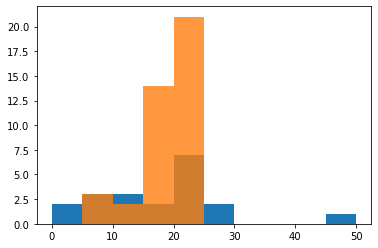

In [48]:
binwidth=5
plt.hist(y_test, label='measured slope',bins=range(int(0), int(50) + binwidth, binwidth))
plt.hist(y_hat, label='predicted slope',bins=range(int(0), int(50) + binwidth, binwidth), alpha=0.8)

Text(0, 0.5, 'Number of bootstrapping')

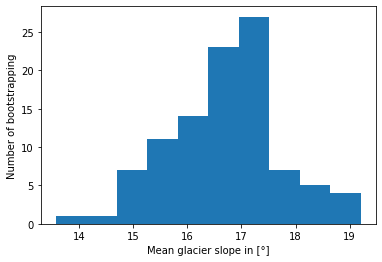

In [49]:
# plot the mean of predicted slope for bootstrapping (k=100)
plt.hist(mean_l)
plt.xlabel('Mean glacier slope in [°]')
plt.ylabel('Number of bootstrapping')


Text(0, 0.5, 'Number of bootstrapping')

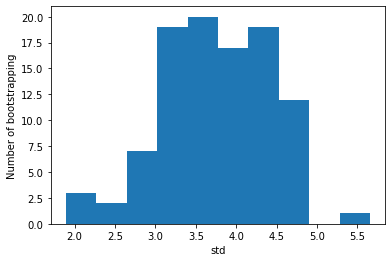

In [50]:
# plot the standard deviation for bootstrapping (k=100)
plt.hist(std_l)
plt.xlabel('std')
plt.ylabel('Number of bootstrapping')

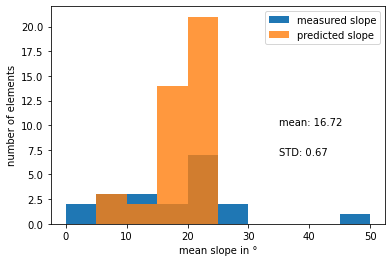

In [51]:
binwidth=5
plt.hist(y_test, label='measured slope',bins=range(int(0), int(50) + binwidth, binwidth))
plt.hist(y_hat, label='predicted slope',bins=range(int(0), int(50) + binwidth, binwidth), alpha=0.8)
plt.legend()
plt.xlabel('mean slope in °')
plt.ylabel('number of elements')
plt.text(35,10,'mean: '+str(round(np.nanmean(mean_l),2)))
plt.text(35,7,'STD: '+str(round(np.std(std_l),2)))
plt.show()

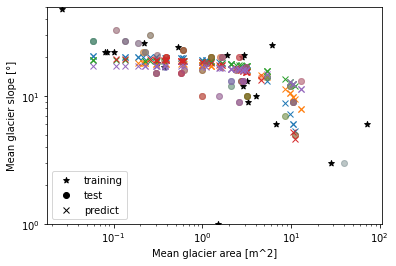

In [52]:
# plot first 5 training sets and precictions plus the test data
for i in range(5): # plot only the first 5 training sets
    color='C{}'.format(i)
    plt.plot(X_bs_l[i].area, y_bs_l[i], 'o', color=color, alpha=0.25) # bootstraped training data set
    plt.plot(X_bs_l[i].area, y_hat_l[i], 'x',color=color) # bootstraped predicted

plt.scatter(X_test, y_test, marker='*', color='black', label='training') # test data set  
plt.plot(np.nan, color='black', marker='o', linestyle='', label='test')
plt.plot(np.nan, color='black', marker='x', linestyle='', label='predict')
plt.ylim(1,50)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean glacier area [m^2]')
plt.ylabel('Mean glacier slope [°]')
plt.legend(loc='lower left')

### d) Predict the thickness of a glacier (2 points)

Let assume that you measure a glacier of area 10 km$^2$. Can you use your bootstrap regression framework to provide a distribution of possible values of the ice thickness ? Output the mean and standard deviation of the predicted ice thickness.

In [53]:
# solution
df_10['pred'] = y_10_l # add the predictions to df
df_10.head()


,area,pred
0,10,6.851512
1,10,10.307057
2,10,12.715015
3,10,6.082989
4,10,12.793053


Text(0, 0.5, 'number of elements')

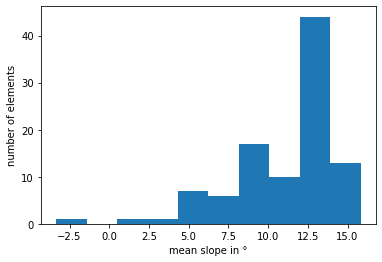

In [54]:
# plot prediction for glacier area = 10 km^2 as histogram
plt.hist(df_10['pred'])
plt.xlabel('mean slope in °')
plt.ylabel('number of elements')

In [55]:
k=100